<a href="https://colab.research.google.com/github/danilodioliveira/Fraud_Detection/blob/main/Fraud_Detection.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# **Health Insurance**

https://www.kaggle.com/ntnu-testimon/paysim1/tasks

# Features Descriptions



# <font color = 'green'> **Ciclo 01** 

# 0.0. Imports

In [1]:
!pip install --upgrade pip

In [6]:
!pip install inflection;
!pip install boruta;
# !pip install git+https://github.com/psycopg/psycopg3.git#subdirectory=psycopg3;
!pip install psycopg3

In [8]:
import psycopg3

ModuleNotFoundError: No module named 'psycopg3'

In [4]:
# import psycopg3
import postgresql
import math
import numpy  as np
import pandas as pd
import random
import pickle
import requests
import warnings
import inflection
import seaborn as sns
import xgboost as xgb

from scipy                 import stats  as ss
from boruta                import BorutaPy
from matplotlib            import pyplot as plt
from IPython.display       import Image
from IPython.core.display  import HTML


from sklearn.metrics       import mean_absolute_error, mean_squared_error
from sklearn.ensemble      import RandomForestRegressor
from sklearn.linear_model  import LinearRegression, Lasso
from sklearn.preprocessing import RobustScaler, MinMaxScaler, LabelEncoder

ModuleNotFoundError: No module named 'psycopg3'


## 0.1. Helper Functions

In [ ]:
warnings.filterwarnings('ignore')

def display_settings():
  %matplotlib inline
  %pylab inline

  plt.style.use( 'bmh' )
  plt.rcParams['figure.figsize'] = [18,10]
  plt.rcParams['font.size'] = 20

  display( HTML( '<style>.container {width:100% !important; }</style>') )
  pd.options.display.max_columns = None
  pd.options.display.max_rows = None
  pd.set_option( 'display.expand_frame_repr', False )

  sns.set()

In [ ]:
display_settings()

## 0.2. Loading Data

In [5]:
##  Database: Postgres 12.0 - AWS
## Credentials:
host = 'comunidade-ds-postgres.c50pcakiuwi3.us-east-1.rds.amazonaws.com'
port = '5432'
db = 'comunidadedsdb'
user = 'member'
pw = 'cdspa'
## problema de negócio: https://sejaumdatascientist.com/como-usar-data-science-para-fazer-a-empresa-vender-mais/

In [10]:
connector = psycopg3.connect( host = host, port = port, dbname = db, user = user, password = pw)
cur = conn.cursor()

cur.execute("SELECT * FROM information_schema.tables WHERE table_type = 'BASE TABLE' AND table_schema = 'pa004'")
cols = [desc[0] for desc in cur.description ]

tables_name = []
for i in cur:
    tables_name.append(i)

table_name = pd.DataFrame( tables_name, columns = cols)
table_name

ValueError: PQ-IRI scheme is not 'pq'

In [120]:
df_raw = pd.read_csv('/content/drive/MyDrive/DataScience/Projects/Fraud Detection/Data/PS_20174392719_1491204439457_log.csv')


In [121]:
df_reduzido = df_raw.sample(100000)

# 1.0. Data Description

In [122]:
df1 = df_reduzido.copy()

## 1.1. Rename Columns

In [123]:
df1.columns

Index(['step', 'type', 'amount', 'nameOrig', 'oldbalanceOrg', 'newbalanceOrig',
       'nameDest', 'oldbalanceDest', 'newbalanceDest', 'isFraud',
       'isFlaggedFraud'],
      dtype='object')

In [124]:
cols_old = ('step', 'type', 'amount', 'nameOrig', 'oldbalanceOrig', 'newbalanceOrig',
       'nameDest', 'oldbalanceDest', 'newbalanceDest', 'isFraud',
       'isFlaggedFraud')

In [125]:
snakecase = lambda x: inflection.underscore( x)

cols_new = list(map( snakecase, cols_old) )

df1.columns = cols_new
df1.columns

Index(['step', 'type', 'amount', 'name_orig', 'oldbalance_orig',
       'newbalance_orig', 'name_dest', 'oldbalance_dest', 'newbalance_dest',
       'is_fraud', 'is_flagged_fraud'],
      dtype='object')

## 1.2. Data Dimensions

In [126]:
print('The dataset has {} columns'.format(df1.shape[1] ) )
print('The dataset has {} rows'.format(df1.shape[0] ) )

The dataset has 11 columns
The dataset has 100000 rows


## 1.3. Data Type

In [127]:
df1.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 100000 entries, 5878692 to 3867812
Data columns (total 11 columns):
 #   Column            Non-Null Count   Dtype  
---  ------            --------------   -----  
 0   step              100000 non-null  int64  
 1   type              100000 non-null  object 
 2   amount            100000 non-null  float64
 3   name_orig         100000 non-null  object 
 4   oldbalance_orig   100000 non-null  float64
 5   newbalance_orig   100000 non-null  float64
 6   name_dest         100000 non-null  object 
 7   oldbalance_dest   100000 non-null  float64
 8   newbalance_dest   100000 non-null  float64
 9   is_fraud          100000 non-null  int64  
 10  is_flagged_fraud  100000 non-null  int64  
dtypes: float64(5), int64(3), object(3)
memory usage: 9.2+ MB


In [128]:
df1.sample(2)

,step,type,amount,name_orig,oldbalance_orig,newbalance_orig,name_dest,oldbalance_dest,newbalance_dest,is_fraud,is_flagged_fraud
998959,45,PAYMENT,8337.56,C2012110802,58.00,0.00,M2048901882,0.0,0.0,0,0
598634,33,PAYMENT,1136.15,C1849257366,11584.48,10448.33,M1849095459,0.0,0.0,0,0


## 1.4. Change Types

In [129]:
#procurar entender o porque!!!
# df1['is_frad'] = df1['is_fraud'].map({1: 'yes', 0: 'no'} )
# df1['is_flagged_fraud'] = df1['is_flagged_fraud'].map({1: 'yes', 0: 'no'} )


## 1.5. NA Check

In [130]:
df1.isna().sum()

step                0
type                0
amount              0
name_orig           0
oldbalance_orig     0
newbalance_orig     0
name_dest           0
oldbalance_dest     0
newbalance_dest     0
is_fraud            0
is_flagged_fraud    0
dtype: int64

## 1.6. Fillout NA

## 1.7. Check Balanced Data

In [131]:
df1['is_fraud'].value_counts( normalize = True)

0    0.9985
1    0.0015
Name: is_fraud, dtype: float64

## 1.8. Desciptive Statistical

In [132]:
num_attributes = df1.select_dtypes( include = ['int64', 'float64'] )
cat_attributes = df1.select_dtypes( exclude = ['int64', 'float64'] )

<font color = 'red'> Porque is_fraud e is_flagged_fraud foram colocadas como object???

### 1.8.1 Numerical Attributes

In [133]:
describe = num_attributes.describe().T


describe['range'] = num_attributes.max() - num_attributes.min().tolist()
describe['variation_coefficicient'] = (num_attributes.std() / num_attributes.mean() ). tolist()
describe['skew'] = num_attributes.skew().tolist()
describe['kurtosis'] = num_attributes.kurtosis().tolist()

describe


,count,mean,std,min,25%,50%,75%,max,range,variation_coefficicient,skew,kurtosis
step,100000.0,2.435144e+02,1.428091e+02,1.00,155.0000,239.000,3.350000e+02,7.370000e+02,7.360000e+02,0.586450,0.377434,0.331015
amount,100000.0,1.773243e+05,5.432734e+05,0.19,13420.2075,74695.495,2.099143e+05,4.710786e+07,4.710786e+07,3.063728,26.524089,1351.223105
oldbalance_orig,100000.0,8.320714e+05,2.884669e+06,0.00,0.0000,14383.500,1.077072e+05,3.307841e+07,3.307841e+07,3.466853,5.268472,33.196845
newbalance_orig,100000.0,8.530161e+05,2.919674e+06,0.00,0.0000,0.000,1.418870e+05,3.334849e+07,3.334849e+07,3.422765,5.196800,32.331340
oldbalance_dest,100000.0,1.100498e+06,3.389585e+06,0.00,0.0000,130957.370,9.325660e+05,1.912797e+08,1.912797e+08,3.080045,16.323125,542.516554
newbalance_dest,100000.0,1.221722e+06,3.609854e+06,0.00,0.0000,211844.670,1.097937e+06,1.919167e+08,1.919167e+08,2.954726,15.815850,506.927901
is_fraud,100000.0,1.500000e-03,3.870097e-02,0.00,0.0000,0.000,0.000000e+00,1.000000e+00,1.000000e+00,25.800646,25.762144,661.701314
is_flagged_fraud,100000.0,0.000000e+00,0.000000e+00,0.00,0.0000,0.000,0.000000e+00,0.000000e+00,0.000000e+00,NaN,0.000000,0.000000


<font color = 'red'> refazer após usar todo o dataset

*   All the data has a coeficient of variation greater than 25%, therefore they are not homoheneous
*   The step has a huge variation, 1 ot 742 hours
*   50% of newbalance_orig is '0' 


### 1.8.2 Categorical Attributes

In [134]:
cat_attributes.describe()

,type,name_orig,name_dest
count,100000,100000,100000
unique,5,99998,92904
top,CASH_OUT,C595376739,C1379289710
freq,35162,2,5


<font color = 'red'> refazer após usar todo o dataset

## 1.9 <font color = 'orange'>não sei como chamar nem onde colocar isso aqui

In [135]:
df1['is_fraud'] = df1['is_fraud'].map({1: 'yes', 0: 'no'} )
df1['is_flagged_fraud'] = df1['is_flagged_fraud'].map({1: 'yes', 0: 'no'})

# 2.0. Feature Engineering

In [136]:
df2 = df1.copy()

## 2.1. Mind Map Hypothesis

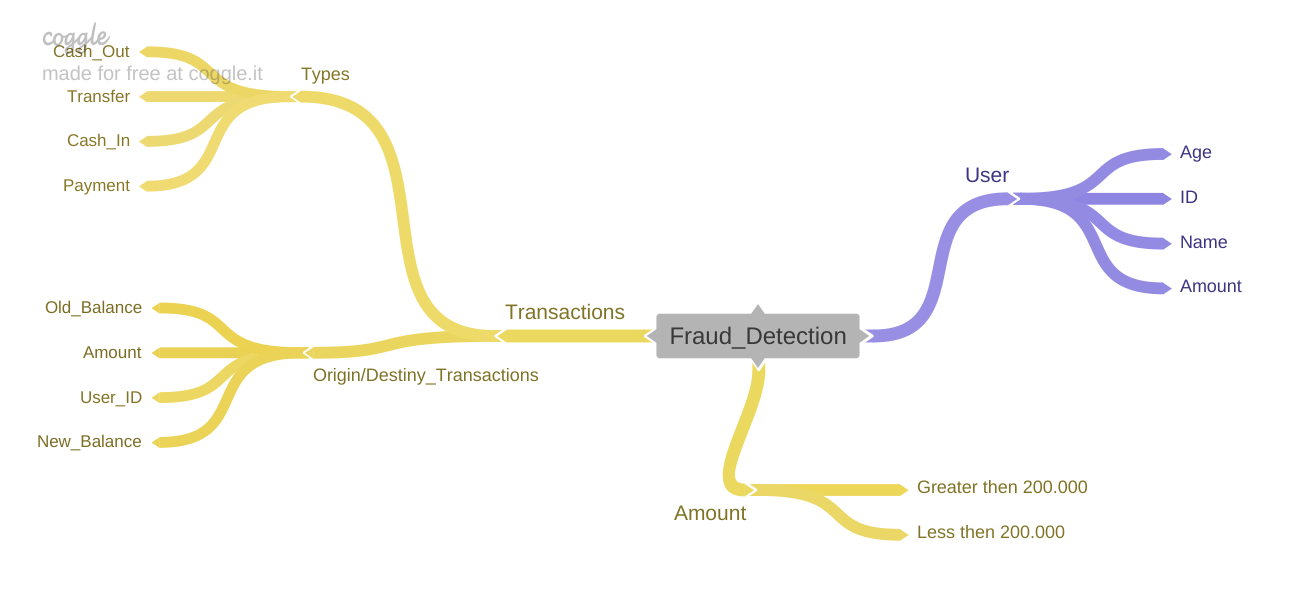

In [137]:
Image('/content/drive/MyDrive/DataScience/Projects/Fraud Detection/Data/MindMap.png')

## 2.2. Hypothesis Creation

In [138]:
df2 = df1.copy()

### 2.2.1 Transactions

**1.** Transactions with lower "step" has a higher chance to be a fraud

**2.** Transactions with "cash-out" type has a higher chance to be a fraud

**3.** Transactions with newbalanceDest = 0 has a higher chance do be a fraud

**4.** Transactions which step is high and transaction  

**5.** Transaction between differents User_ID has a higher chance to be a fraud

**6.** consecutive transactions in the same day has a higher chance to be a fraud

### 2.2.2 User

**7.** Users younger then 21 years old are more susceptible to fraud

**8.** Users older then 60 years old are more susceptible to fraud

**9.** Users with higher funds are more susceptible to fraud

## 2.3. Final Hypothesis

**1.** Transactions with lower "step" has a higher chance to be a fraud

**2.** Transactions with "cash-out" type has a higher chance to be a fraud

**3.** Transactions with newbalanceDest = 0 has a higher chance do be a fraud

**4.** Transactions which step is high and transaction  

**5.** Transaction between differents User_ID has a higher chance to be a fraud

**9.** Users with higher funds are more susceptible to fraud

## 2.4. Feature Engineering

In [139]:
# step
df2['step_days'] = df2['step'].apply(lambda i: i/24)
df2['step_weeks'] = df2['step'].apply(lambda i: i/(24*7) )

# difference between initial and final origin
df2['diff_new_old_origin'] = df2['newbalance_orig'] - df2['oldbalance_orig']

#difference between initial and final destination
df2['diff_new_old_dest'] = df2['newbalance_dest'] - df2['oldbalance_dest']

# 3.0 Data Filtering

In [140]:
df3 = df2.copy()

## 3.1. Filtering Rows

## 3.2. Columns Selection

# 4.0. Exploratory Data Analysis

In [141]:
df4 = df3.copy()

## 4.1. Univariate Analysis

### 4.1.1 Response Variable

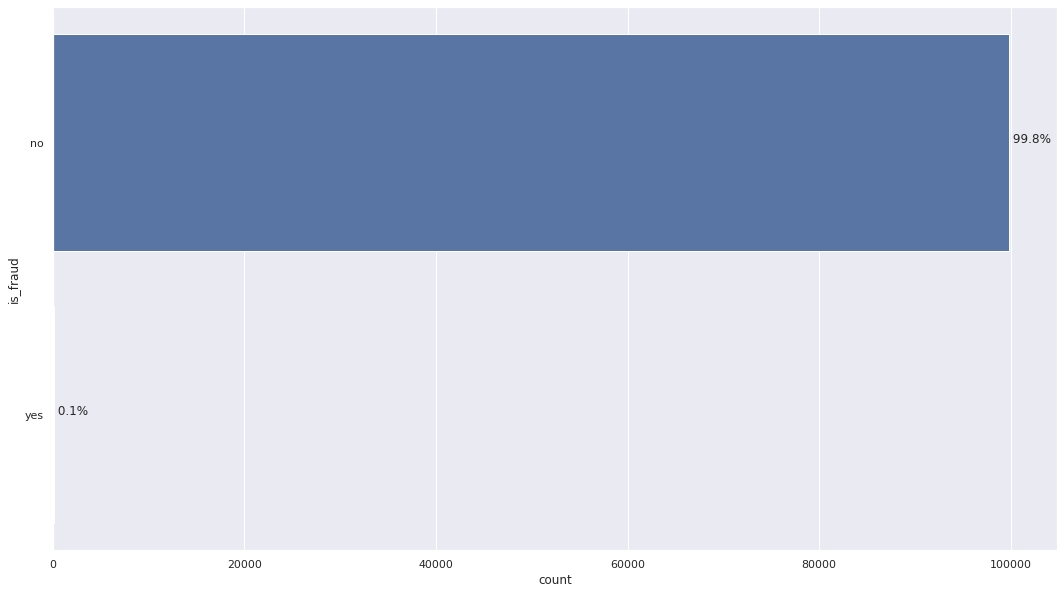

In [142]:
ax = sns.countplot(y = 'is_fraud', data = df4)

total = df4['is_fraud'].size
for p in ax.patches:
        percentage = ' {:.1f}%'.format(100 * p.get_width()/total)
        x = p.get_x() + p.get_width() + 0.02
        y = p.get_y() + p.get_height()/2
        ax.annotate(percentage, (x, y))

### 4.1.2 Numerical Variable

In [143]:
num_attributes = df4.select_dtypes(exclude = 'object')

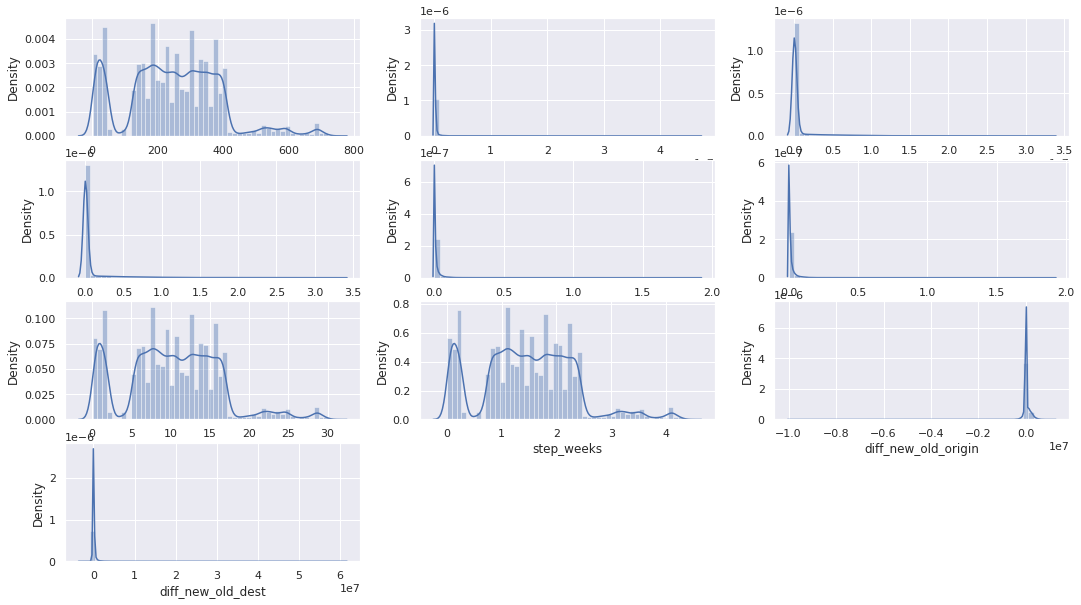

In [144]:
num_a_columns = num_attributes.columns.tolist()
j = 1

for column in num_a_columns:
  plt.subplot(4, 3, j)
  sns.distplot(num_attributes[column] );
  j += 1

### 4.1.3 Categorical Variables

In [145]:
cat_attributes = df4.select_dtypes(include='object')
cat_attributes.columns

Index(['type', 'name_orig', 'name_dest', 'is_fraud', 'is_flagged_fraud'], dtype='object')

In [146]:
# cat_attributes = df4.select_dtypes(include = 'object')
# cat_a_columns = cat_attributes.columns.tolist()

# j = 1

# for column in cat_a_columns:
#   plt.subplot(3, 2, j)
#   ax = sns.countplot(y=column, data=cat_attributes)
    
#   total = cat_attributes[column].size
#   for p in ax.patches:
#       percentage = ' {:.1f}%'.format(100 * p.get_width()/total)
#       x = p.get_x() + p.get_width() + 0.02
#       y = p.get_y() + p.get_height()/2
#       ax.annotate(percentage, (x, y))
    
#   j += 1

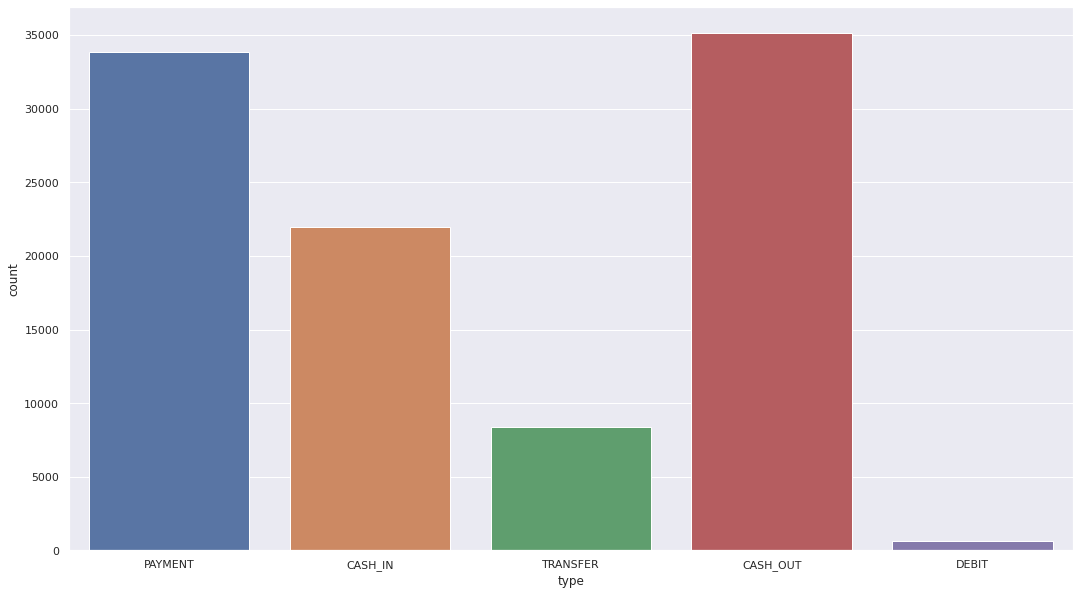

In [147]:
# plt.subplot(1,3,1)
sns.countplot( df4['type'])

# plt.subplot(1,3,2)
# sns.countplot( df4['name_orig'])

# plt.subplot(1,3,3)
# sns.countplot( df4['name_dest'])



## 4.2. Bivariate Analysis

**1.** Transactions with lower "step" has a higher chance to be a fraud

FALSE

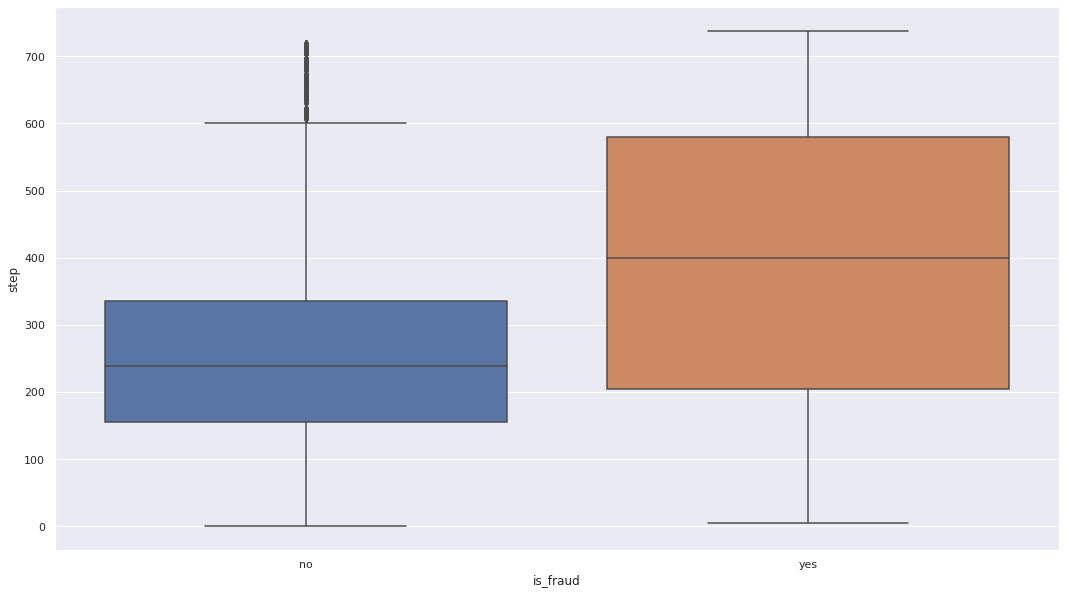

In [148]:
sns.boxplot(x = 'is_fraud', y = 'step', data = df4)

**2.** Transactions with "cash-out" type has a higher chance to be a fraud



In [149]:
df4.columns

Index(['step', 'type', 'amount', 'name_orig', 'oldbalance_orig',
       'newbalance_orig', 'name_dest', 'oldbalance_dest', 'newbalance_dest',
       'is_fraud', 'is_flagged_fraud', 'step_days', 'step_weeks',
       'diff_new_old_origin', 'diff_new_old_dest'],
      dtype='object')

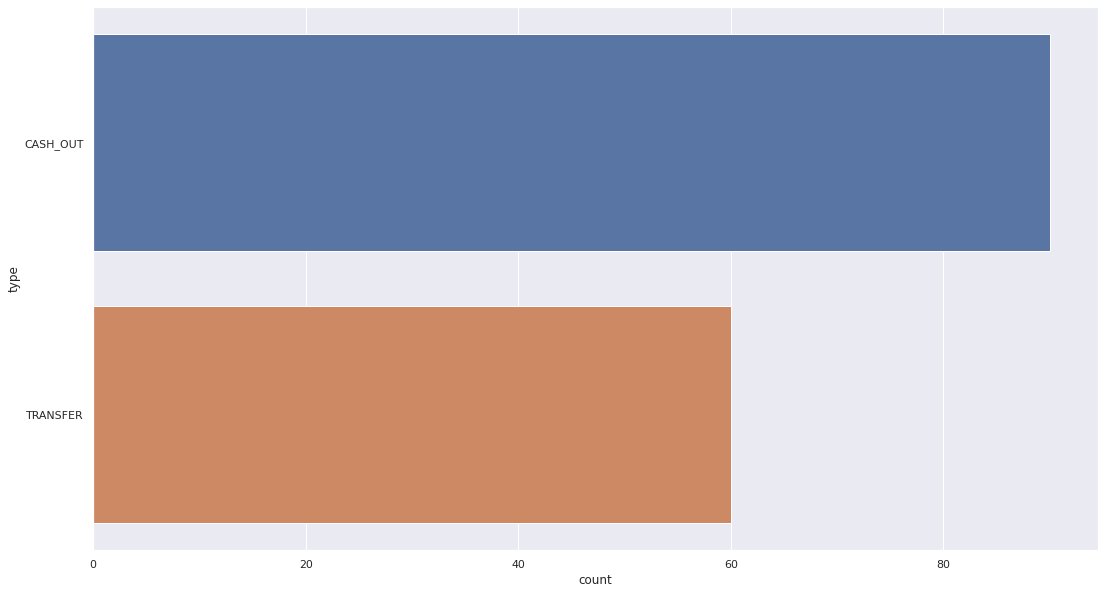

In [150]:
a = df4[df4['is_fraud'] == 'yes' ]
sns.countplot( y = 'type', data = a)

# total = df4['type'].size
# for p in a.patches:
#   percentage = ' {:.1f}%'.format(100 * p.get_width()/total)
#   x = p.get_x() + p.get_width() + 0.02
#   y = p.get_y() + p.get_height()/2
#   a.annotate(percentage, (x, y))

**3.** Transactions with newbalanceOrig = 0 has a higher chance do be a fraud



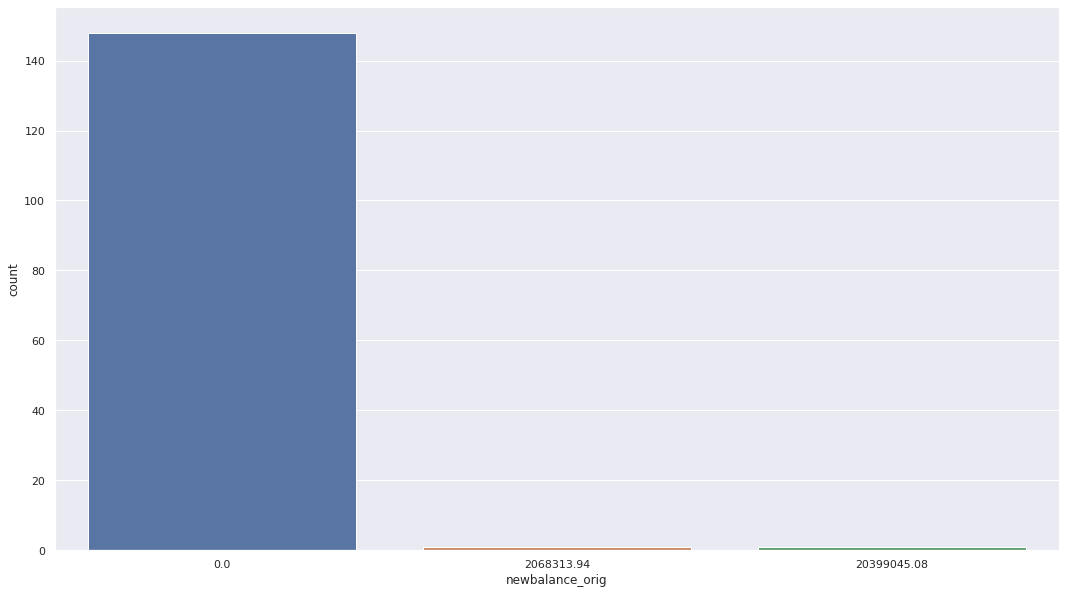

In [151]:
a = df4[df4['is_fraud'] == 'yes' ]
sns.countplot( x = 'newbalance_orig', data = a)

**4.** Transactions which step is high and transaction equal to cash_out has a higher chance to be a fraud



In [152]:
a = df4[df4['step'] > 242]
a = df4[df4['is_fraud'] == 'yes']

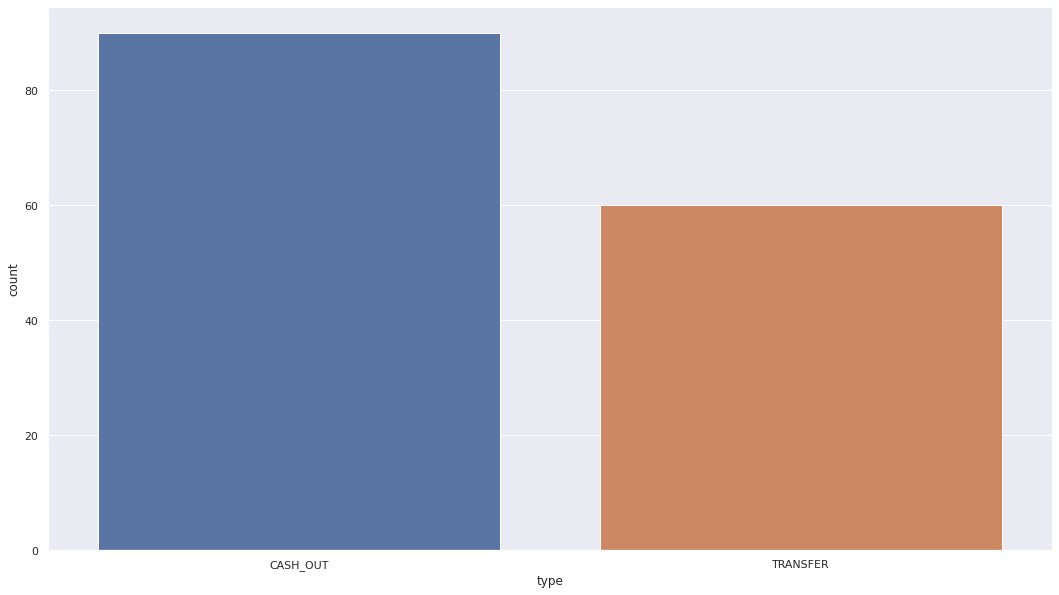

In [153]:
sns.countplot(x = 'type', data = a)

**5.** Transaction between differents User_ID has a higher chance to be a fraud


In [154]:
a = df4[df4['is_fraud'] == 'yes']
b = a[a['name_orig'] != a['name_dest'] ].reset_index()
c = a[a['name_orig'] == a['name_dest'] ].reset_index()

In [155]:
print('A quantidade de transações entre o mesmo usuarios é igual a: {}'.format(len(c)))
print('A quantidade de transações entre usuarios diferentes é igual a: {}'.format(len(b)))

A quantidade de transações entre o mesmo usuarios é igual a: 0
A quantidade de transações entre usuarios diferentes é igual a: 150


**9.** Users with higher funds are more susceptible to fraud


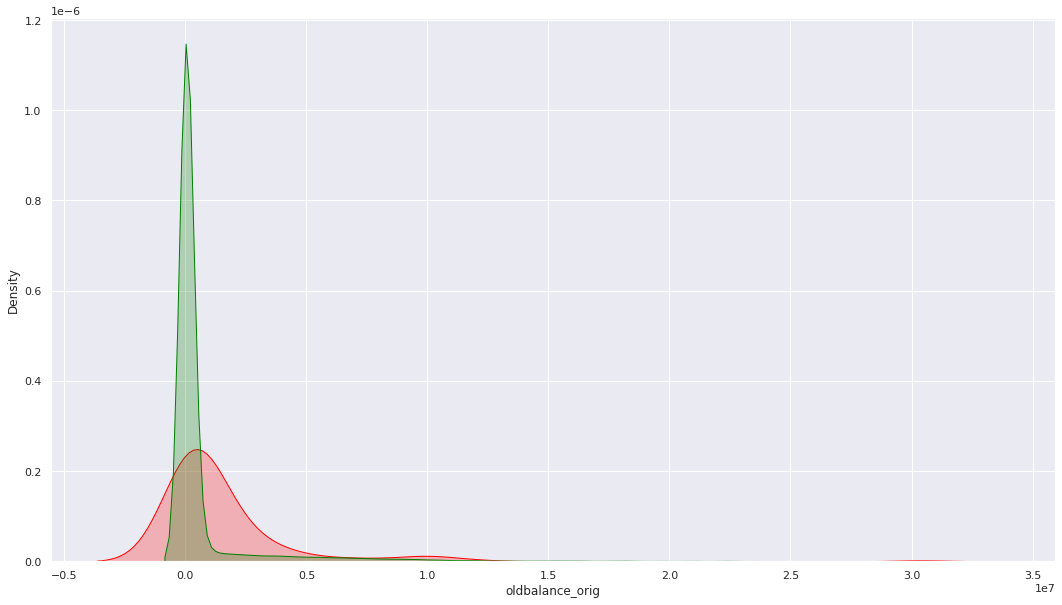

In [164]:
sns.kdeplot(df4[df4['is_fraud'] == 'yes']['oldbalance_orig'], shade = True, color = 'red')
sns.kdeplot(df4[df4['is_fraud'] ==  'no']['oldbalance_orig'], shade = True, color = 'green')

## 4.3. Multivariaty Analysis

### 4.3.1 Numerical Analysis

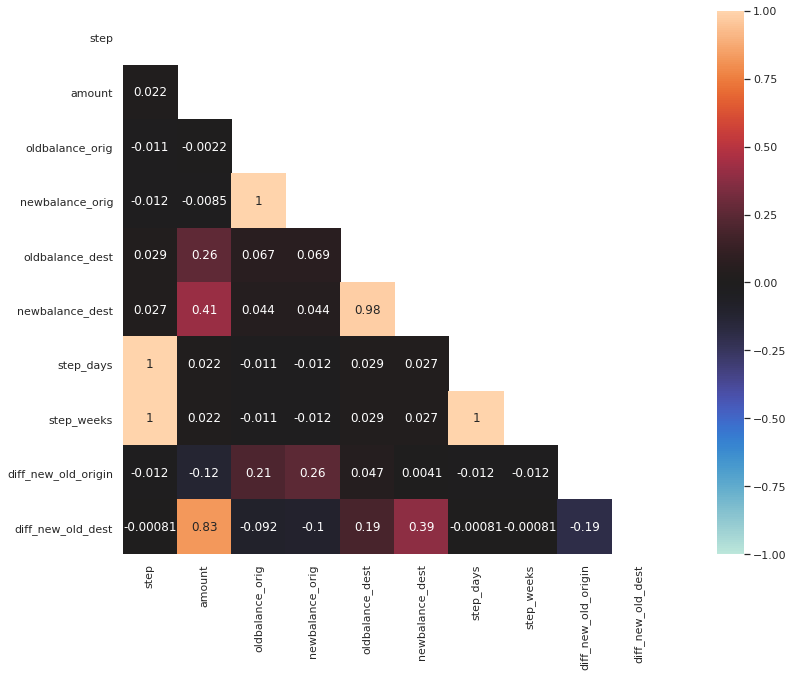

In [168]:
corr = num_attributes.corr()

mask = np.zeros_like(corr)
mask[np.triu_indices_from(mask)] = True

with sns.axes_style('white'):
  ax = sns.heatmap(corr, annot = True, mask = mask, vmin = -1, center = 0, vmax = 1, square = True)

### 4.3.2 Categorical Variables

# 5.0. Data Preparation

In [ ]:
df5 = df4.copy()

# 5.0. Feature Selection

# 6.0. Feature Selection

# 7.0 Machine Learning Model